Aligning HST Data to Gaia (mostly) automatically
==========================

This notebook is designed to show a workflow used to align HST images (in this case ACS/WFC and WFC3/UVIS, though other detectors should work) to catalogs queried programatically from Gaia. Since Gaia's astrometry is generally very good, this provides high-quality absolute catalogs to use to align images.  This especially helpful for cases where data is taken at many pointings with little to no overlap between images (mosaicking). 

<div class="alert alert-block alert-warning">**Note:** This is **not** a guide on running TweakReg, but rather making alignments using TweakReg substantially easier</div>
***

### Table of Contents:
> #### 0. [Setup](#setup)
> #### 1. [Determining Coordinates to Query](#coordinates)
> #### 2. [Querying Catalogs from Gaia](#gaia)
> #### 3. [Aligning Data to Gaia](#alignment)

***
<a id='setup'></a>
## Setup
This notebook was written using a Python 3 astroconda environment, so that is the recommended setup for running it.

In addition, you will need to install Astroquery.  The installation is very straightforward if running astroconda:

`$ conda install -c astropy astroquery`

After running that in a terminal, press `Kernel -> restart` so the package can be loaded.  More information on Astroquery can be found here: http://astroquery.readthedocs.io/en/latest/index.html

Lastly, you will need a set of data to work with.  In this notebook we use example data from Visits 01 and 05 of HST proposal 14689.  You can either retrieve the data from MAST yourself and put it in your current working directory, **or** see the [Querying MAST](#mast) section.

In [1]:
# All packages for entire notebook here, but also imported in first relevant cell


import glob
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

# Astropy packages we'll need
from astropy import units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.visualization import wcsaxes
from astropy.wcs import WCS

# Astroquery packages used for queries
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView

# Drizzle related packages we'll need
from drizzlepac import tweakreg
from stsci.tools import teal
from stwcs import updatewcs

# Other handy parts
from ginga.util import zscale
from multiprocessing import Pool


# Python 2 compatibility
from __future__ import print_function
from __future__ import division

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
No TEAL-based tasks available for this package!
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [2]:
# Some extra configuration 

SkyView.TIMEOUT = 15

mpl.rcParams['xtick.labelsize'] = 10
plt.rcParams.update({'axes.titlesize' : '18',
                     'axes.labelsize' : '14',
                     'xtick.labelsize' : '14',
                     'ytick.labelsize' : '14'})
%matplotlib inline

***
<a id='coordinates'></a>
## 1. Determining Coordinates

First, we need to create a SkyCoord object to tell the Gaia query where to point.  This can be done in a number of ways:
>1. If coordinates are known, create the SkyCoord Object directly.
>2. Query Simbad for the target coordinates.
>3. Obtain coordinates using WCS information in data (recommended).

We also need to supply the search area of the query.  If we know roughly how large the field is, then this is obviously straightforward.  If not, option 3 is likely the easiest way.

   ### a. Coordinates already known

In [3]:
# Option 1- Coordinates known
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord

# RA in HH:MM:SS Dec in DD:MM:SS
coord = SkyCoord(ra='05:22:06.9', dec='-67:56:46',unit=(u.hourangle,u.deg))   # Need to specify units
print(coord)

# RA in and Dec in decimal degrees
coord = SkyCoord(ra=80.52875, dec=-67.94611111, unit=u.deg)
print(coord)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 80.52875, -67.94611111)>
<SkyCoord (ICRS): (ra, dec) in deg
    ( 80.52875, -67.94611111)>


### b. Query Simbad for object coordinates

In [4]:
# Option 2- Query Simbad for Object
from astroquery.simbad import Simbad

result = Simbad.query_region('lmc-n44')  # Search by target name, returns an astropy table
first_object = result[0]

object_name = first_object['MAIN_ID'].decode("utf-8")  # Query returns target name as a byte string, 
RA = first_object['RA']                                   # the .decode("utf-8") converts to normal string
Dec = first_object['DEC']

print('Target: {},   RA: {},   Dec: {}\n'.format(object_name, RA, Dec))

coord = SkyCoord(ra=RA, dec=Dec, unit=(u.hourangle,u.deg)) 
print(coord)

result # Just to show the results of the Simbad query, many columns of information available in table

Target: LHA 120-N  44,   RA: 05 22 06.9,   Dec: -67 56 46

<SkyCoord (ICRS): (ra, dec) in deg
    ( 80.52875, -67.94611111)>


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,RA_2,COO_ERR_ANGLE,DEC_2,RA_PREC_2,DEC_PREC_2,COO_ERR_MAJA_2,COO_ERR_MINA_2,COO_ERR_ANGLE_2,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,"""h:m:s""",deg,"""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,str13,int16,str13,int16,int16,float32,float32,int16,str1,str1,object
LHA 120-N 44,05 22 06.9,-67 56 46,5,5,--,--,05 22 06.9,0,-67 56 46,5,5,--,--,0,D,O,2012ApJ...755...40P
2MASS J05220748-6756457,05 22 07.6300,-67 56 45.212,8,8,300.000,300.000,05 22 07.6300,90,-67 56 45.212,8,8,300.000,300.000,90,C,I,2009AJ....138.1003B
[CCG2009] J052207.7-675649.4,05 22 07.65,-67 56 49.2,6,6,300.000,300.000,05 22 07.65,90,-67 56 49.2,6,6,300.000,300.000,90,C,I,2009ApJ...695..511C
[OM95] LH 47-270,05 22 06.47,-67 56 51.0,6,6,--,--,05 22 06.47,0,-67 56 51.0,6,6,--,--,0,D,,
[OM95] LH 47-282,05 22 07.69,-67 56 39.8,6,6,--,--,05 22 07.69,0,-67 56 39.8,6,6,--,--,0,D,,
[OM95] LH 47-272,05 22 06.83,-67 56 54.0,6,6,--,--,05 22 06.83,0,-67 56 54.0,6,6,--,--,0,D,,
[OM95] LH 47-257,05 22 05.43,-67 56 45.4,6,6,--,--,05 22 05.43,0,-67 56 45.4,6,6,--,--,0,D,,
[OM95] LH 47-286,05 22 08.44,-67 56 41.8,6,6,--,--,05 22 08.44,0,-67 56 41.8,6,6,--,--,0,D,,


### c. Determine coordinates and search area from the WCS's of your images (coolest option)

To calculate the coordinates and the search area necessary, we open each input image we want to align and get the WCS information.

We then record the positions of all the corners of the images in sky space (RA and Dec), and take the min, max, and midpoints in each dimension to determine where and how wide we want to query our coordinates.

In [5]:
# Option 3- Determine coordinates from data
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import wcsaxes

from matplotlib.patches import Polygon
import matplotlib.cm as cm


# ----------------------------------------------------------------------------------------------------------

# 
def get_footprints(im_name):
    """Calculates positions of the corners of the science extensions of some image 'im_name' in sky space"""
    footprints = []
    hdu = fits.open(im_name)
    
    flt_flag = 'flt.fits' in im_name or 'flc.fits' in im_name
    
    # Loop ensures that each science extension in a file is accounted for.  This is important for 
    # multichip imagers like WFC3/UVIS and ACS/WFC
    for ext in hdu:
        if 'SCI' in ext.name:
            hdr = ext.header
            wcs = WCS(hdr, hdu)
            footprint = wcs.calc_footprint(hdr, undistort=flt_flag)
            footprints.append(footprint)
    
    hdu.close()
    return footprints

# ----------------------------------------------------------------------------------------------------------
def bounds(footprint_list):
    """Calculate RA/Dec bounding box properties from multiple RA/Dec points"""
    
    # flatten list of extensions into numpy array of all corner positions
    merged = [ext for image in footprint_list for ext in image]
    merged = np.vstack(merged)
    ras, decs = merged.T
    
    # Compute width/height
    delta_ra = (max(ras)-min(ras))
    delta_dec = max(decs)-min(decs)

    # Compute midpoints
    ra_midpt = (max(ras)+min(ras))/2.
    dec_midpt = (max(decs)+min(decs))/2.
    

    return ra_midpt, dec_midpt, delta_ra, delta_dec
# ----------------------------------------------------------------------------------------------------------

            
images = glob.glob('*fl?.fits')
footprint_list = list(map(get_footprints, images))

# # If that's slow, here's a version that runs it in parallel:
# from multiprocessing import Pool
# p = Pool(8)
# footprint_list = list(p.map(get_footprints, images))
# p.close()
# p.join()


ra_midpt, dec_midpt, delta_ra, delta_dec = bounds(footprint_list)

coord = SkyCoord(ra=ra_midpt, dec=dec_midpt, unit=u.deg)
print(coord)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 80.81052589, -67.99202175)>


Doing this programatically also makes plotting the footprints of our images very easy.

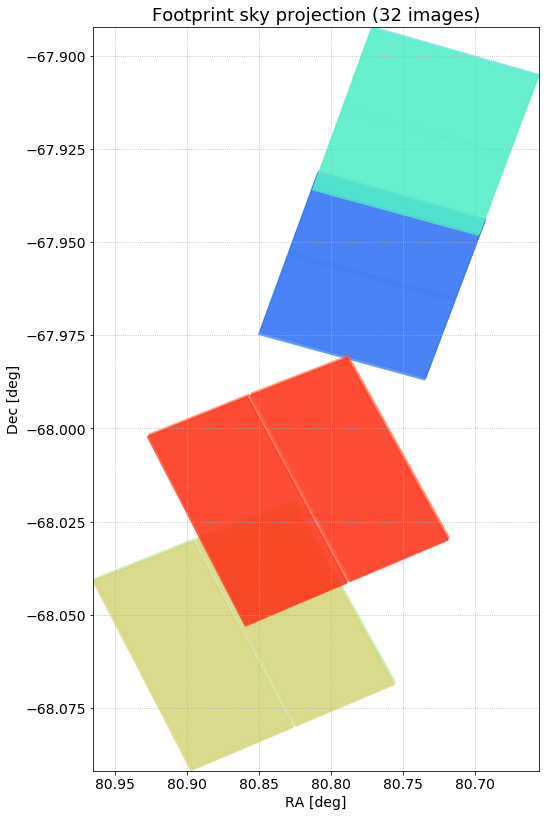

In [6]:
def plot_footprints(footprint_list, axes_obj=None, fill=True):
    """Plots the footprints of the images on sky space on axes specified by axes_obj """
    
    if axes_obj != None: 
        ax = axes_obj
    
    else: # If no axes passed in, initialize them now
        merged = [ext for image in footprint_list for ext in image] # flatten list of RA/Dec
        merged = np.vstack(merged)
        ras, decs = merged.T
        
        # Calculate aspect ratio
        delta_ra = (max(ras)-min(ras))*np.cos(math.radians(min(np.abs(decs))))
        delta_dec = max(decs)-min(decs)
        aspect_ratio = delta_dec/delta_ra
    
        # Initialize axes
        fig = plt.figure(figsize=[8,8*aspect_ratio])
        ax = fig.add_subplot(111)
        ax.set_xlim([max(ras),min(ras)])
        ax.set_ylim([min(decs),max(decs)])
       
        # Labels
        ax.set_xlabel('RA [deg]')
        ax.set_ylabel('Dec [deg]')
        ax.set_title('Footprint sky projection ({} images)'.format(len(footprint_list)))
        
        ax.grid(ls = ':')
    
        
    colors = cm.rainbow(np.linspace(0, 1, len(footprint_list)))
    alpha = 1./float(len(footprint_list)+1.)+.2
    
    if not fill:
        alpha =.8

    for i, image in enumerate(footprint_list): # Loop over images
        for ext in image: # Loop over extensions in images
            if isinstance(ax, wcsaxes.WCSAxes): # Check axes type
                rect = Polygon(ext, alpha=alpha, closed=True, fill=fill, 
                               color=colors[i], transform=ax.get_transform('icrs'))
            else:
                rect = Polygon(ext, alpha=alpha, closed=True, fill=fill, color=colors[i])

            ax.add_patch(rect)
    
    return ax

# ----------------------------------------------------------------------------------------------------------

plot_footprints(footprint_list)

***
<a id='gaia'></a>
## 2. Querying Gaia (and other databases)

With the coordinates calculated, we now only need to give the search area and perform the query.  Most astroquery supported missions/databases can be passed width/height (for a rectangular search) or a radius (for a circular search).  In either case, these parameters can be passed using astropy.units Quantity 

In [7]:
from astropy.units import Quantity
from astroquery.gaia import Gaia

width = Quantity(delta_ra, u.deg)
height = Quantity(delta_dec, u.deg)

### a. Querying Gaia
Performing the query is very simple thanks to Astroquery's Gaia API:

In [8]:
# Perform the query!
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),                 POINT('ICRS',80.8105238961169,-67.99202680591918)) AS dist, *                 FROM gaiadr1.gaia_source WHERE CONTAINS(                POINT('ICRS',ra,dec),                BOX('ICRS',80.8105238961169,-67.99202680591918, 0.31006131516150504, 0.1996912317901547))=1                 ORDER BY dist ASC'
Retrieving async. results...
Query finished.


The query returns an astropy table with the number of rows equal to the number of sources returned (with many output columns):

In [9]:
# Print the table
r

dist,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_good_obs_ac,astrometric_n_bad_obs_al,astrometric_n_bad_obs_ac,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,astrometric_relegation_factor,astrometric_weight_al,astrometric_weight_ac,astrometric_priors_used,matched_observations,duplicated_source,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
,,,,Time[Julian Years],deg,Angle[mas],deg,Angle[mas],Angle[mas],Angle[mas],mas / yr,mas / yr,mas / yr,mas / yr,Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],,,,,,,,Angle[mas],,,,Angle[mas^-2],Angle[mas^-2],,,,,,,,deg,deg,deg,deg,,Flux[e-/s],Flux[e-/s],Magnitude[mag],Dimensionless[see description],deg,deg,deg,deg
float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,float32,float64,float64,bool,float32,float32,float32,int32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,object,float64,float64,float64,float64
0.0011122837159697459,1635378410781933568,4658737385175628800,830592415,2015.0,80.807587088669749,7.0709611726400157,-67.992188129397121,7.8336647973176383,--,--,--,--,--,--,0.84609997,--,--,--,--,--,--,--,--,--,28,0,28,0,0,0,--,0.0,0.0,False,1.0,0.023108331,--,2,11,False,0.30835506,0.49368355,0.27261627,0.67287517,-85.094284,-33.605667,41.582275,-9.0339708,71,172.12699591515579,2.9229771521503958,19.935147590846384,NOT_AVAILABLE,278.3995841119264,-33.227979356433998,333.84619771304926,-86.175991729833214
0.0014600816062492292,1635378410781933568,4658737389458557696,482134372,2015.0,80.814165517692942,1.7197268644030634,-67.991507633743055,5.3021006888737077,--,--,--,--,--,--,0.77745003,--,--,--,--,--,--,--,--,--,32,0,32,0,0,0,--,0.0,0.0,False,1.0,0.051368844,--,2,12,False,0.50289518,0.44564313,0.67425984,0.6711576,-99.475021,-60.133633,40.188496,-0.79853213,77,257.96740104473901,2.3113001862194835,19.495857993127057,NOT_AVAILABLE,278.39829265019029,-33.225661350263032,333.84469601029298,-86.178547158533945
0.0030736825018595633,1635378410781933568,4658737385156435328,164048409,2015.0,80.814509083246165,0.28544591406537823,-67.994713358454334,0.54841522199134551,--,--,--,--,--,--,0.032249998,--,--,--,--,--,--,--,--,--,63,63,63,57,0,6,--,1.5868299258171215,420.87313726486752,False,15.412125,0.39646143,0.32379162,2,14,False,0.39559913,0.084510252,0.14470425,0.26119527,-125.09865,-79.453529,-23.885693,10.219987,106,267752.79547599104,4178.3366380177877,11.955435029380903,NOT_AVAILABLE,278.40204615995492,-33.225002327889108,333.79829170181461,-86.177695025221624
0.0030814108605326847,1635378410781933568,4658737385175655424,1127956992,2015.0,80.818295233229222,6.0778588478540616,-67.991019912679903,40.662539073357514,--,--,--,--,--,--,0.98570001,--,--,--,--,--,--,--,--,--,28,0,28,0,0,0,--,1.5000246706581974,0.59987709835314162,False,1.2462406,0.059147,--,2,11,False,0.56879002,0.51005644,0.91333443,0.73766971,-113.81963,-68.193558,40.309525,1.86369,72,323.70652280154718,2.87025619

Accessing the data is quite straightforward, plotting the data for quick analytics is also straightforward.

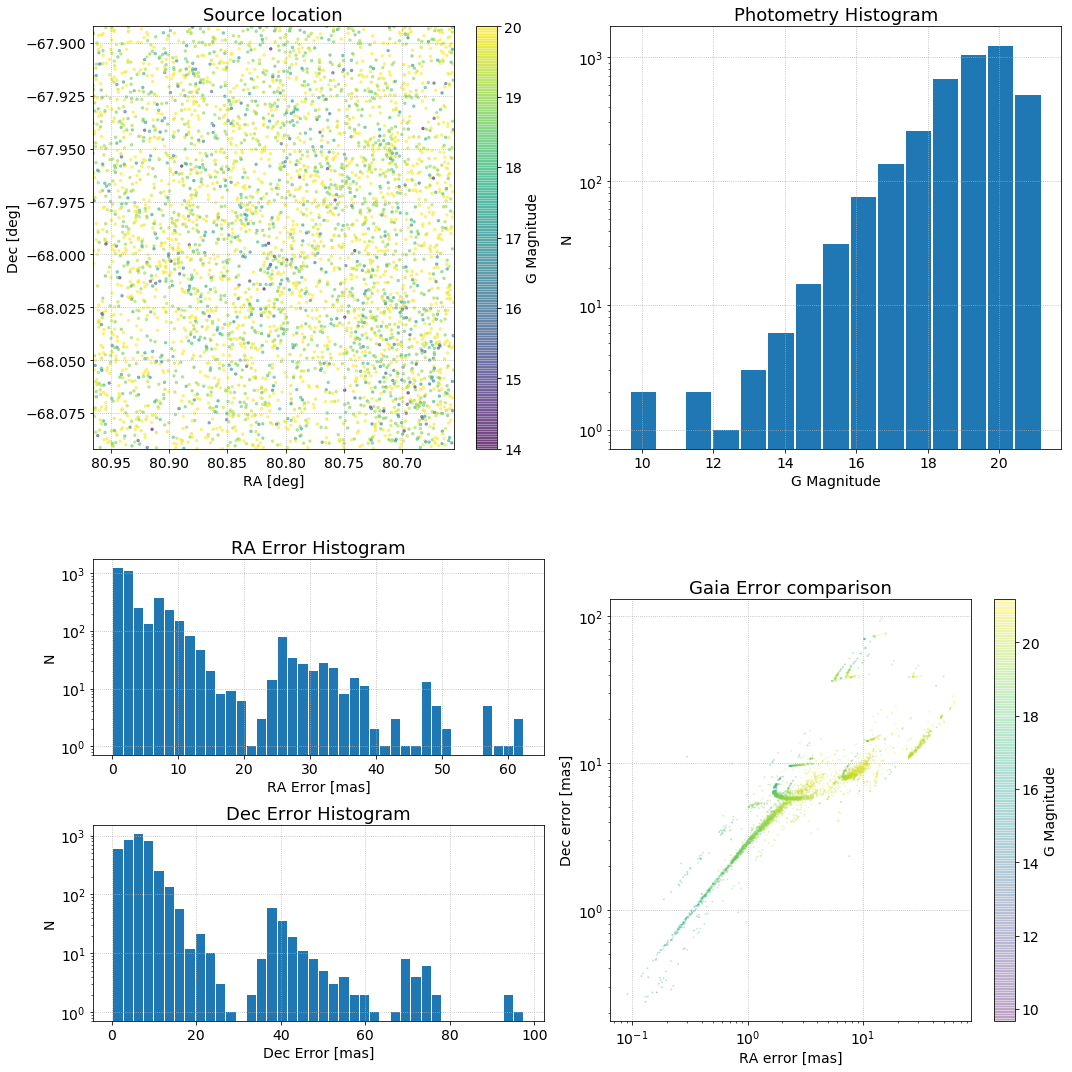

In [10]:
ras = r['ra']
decs = r['dec']
mags = r['phot_g_mean_mag']
ra_error = r['ra_error']
dec_error = r['dec_error']

fig = plt.figure(figsize=[15,15])

# Plot RA and Dec positions, color points by G magnitude
ax1 = fig.add_subplot(221)
plt.scatter(ras,decs,c=mags,alpha=.5,s=6,vmin=14,vmax=20)
ax1.set_xlim(max(ras),min(ras))
ax1.set_ylim(min(decs),max(decs))
ax1.grid(ls = ':')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('Dec [deg]')
ax1.set_title('Source location')
cb = plt.colorbar()
cb.set_label('G Magnitude')

# Plot photometric histogram
ax2 = fig.add_subplot(222)
hist, bins, patches = ax2.hist(mags,bins=15,rwidth=.925)
ax2.grid(ls = ':')
ax2.set_xlabel('G Magnitude')
ax2.set_ylabel('N')
ax2.set_title('Photometry Histogram')
ax2.set_yscale("log")


ax3a = fig.add_subplot(425)
hist, bins, patches = ax3a.hist(ra_error,bins=40,rwidth=.9)
ax3a.grid(ls = ':')
ax3a.set_title('RA Error Histogram')
ax3a.set_xlabel('RA Error [mas]')
ax3a.set_ylabel('N')
ax3a.set_yscale("log")

ax3b = fig.add_subplot(427)
hist, bins, patches = ax3b.hist(dec_error,bins=40,rwidth=.9)
ax3b.grid(ls = ':')
ax3b.set_title('Dec Error Histogram')
ax3b.set_xlabel('Dec Error [mas]')
ax3b.set_ylabel('N')
ax3b.set_yscale("log")


ax4 = fig.add_subplot(224)
plt.scatter(ra_error,dec_error,alpha=.2,c=mags,s=1)
ax4.grid(ls = ':')
ax4.set_xlabel('RA error [mas]')
ax4.set_ylabel('Dec error [mas]')
ax4.set_title('Gaia Error comparison')
ax4.set_xscale("log")
ax4.set_yscale("log")
cb = plt.colorbar()
cb.set_label('G Magnitude')
plt.tight_layout()

Filtering the data is also quite easy:

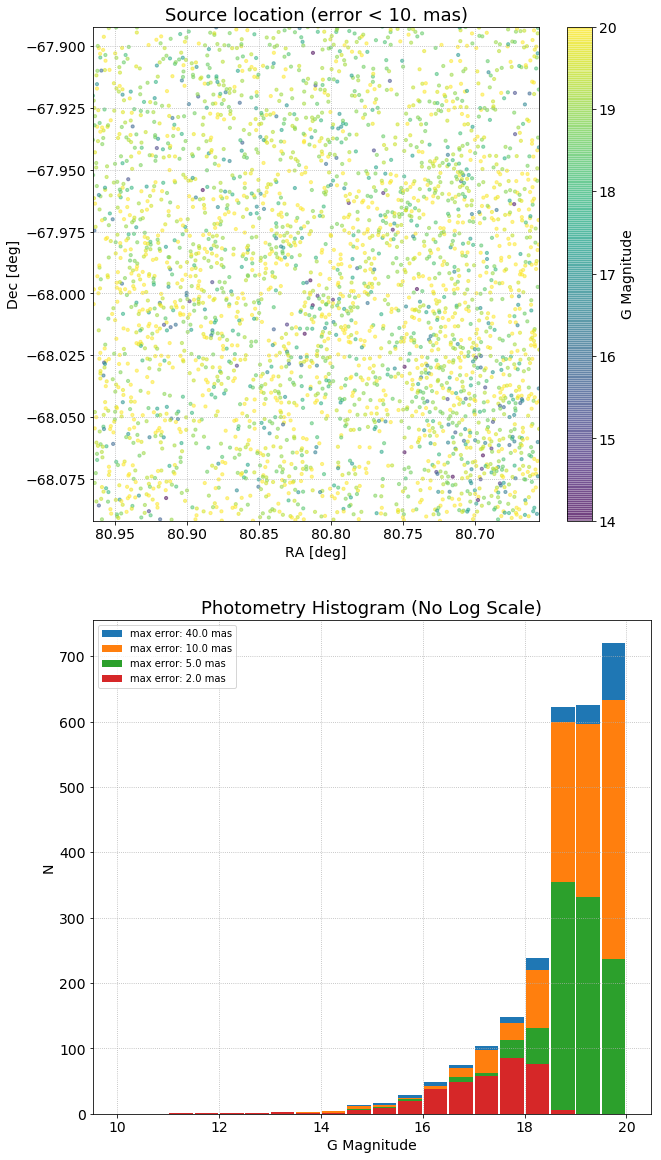

In [11]:
# Cut the sources

def get_error_mask(catalog, max_error):
    """Returns a mask for rows in catalog where RA and Dec error are less than max_error"""
    ra_mask = catalog['ra_error']< max_error
    dec_mask = catalog['dec_error'] < max_error
    mask = ra_mask & dec_mask
#     print('Cutting sources with error higher than {}'.format(max_error))
#     print('Number of sources befor filtering: {}\nAfter filtering: {}\n'.format(len(mask),sum(mask)))
    return mask

mask = get_error_mask(r, 10.)
# Plot RA/Dec Positions after clipping 

fig = plt.figure(figsize=[10,20])
ax1 = fig.add_subplot(211)
plt.scatter(ras[mask],decs[mask],c=mags[mask],alpha=.5,s=10,vmin=14,vmax=20)
ax1.set_xlim(max(ras),min(ras))
ax1.set_ylim(min(decs),max(decs))
ax1.grid(ls = ':')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('Dec [deg]')
ax1.set_title('Source location (error < 10. mas)')
cb = plt.colorbar()
cb.set_label('G Magnitude')


ax2 = fig.add_subplot(212)
for err_threshold in [40., 10., 5., 2.]:
    mask = get_error_mask(r, err_threshold)
    hist, bins, patches = ax2.hist(mags[mask],bins=20,rwidth=.925,
                                   range=(10,20),label='max error: {} mas'.format(err_threshold))
ax2.grid(ls = ':')
ax2.set_xlabel('G Magnitude')
ax2.set_ylabel('N')
ax2.set_title('Photometry Histogram (No Log Scale)')
# ax2.set_yscale("log")
legend = ax2.legend(loc='best')

<a id='mast'></a>
### b. Querying MAST (not necessary, but possibly useful)
Astroquery has access to many other databases: http://astroquery.readthedocs.io/en/latest/index.html#available-services, which can be used to query objects from numerous other surveys and archives (as we did above with SIMBAD).   We can also query and download a variety of data from many missions, including those hosted by MAST.  As an example, we query and download the data used in this example notebook.

<div class="alert alert-block alert-info">To skip this section and continue with aligning the data, proceed to the [alignment](#alignment) section.</div>

First, we need to query MAST and get the information about observations:

In [12]:
from astroquery.mast import Observations

# Query the ACS and WFC3 obervations from visits 1 and 2 from HST program 14689
obsTable = Observations.query_criteria(project='HST',proposal_id='14689',obs_id='[IJ]D730[15]*')

In [13]:
# Show the results of the observations query
obsTable

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,dataRights,mtFlag,srcDen,instrument_name,proposal_pi,proposal_id,project,s_region,jpegURL,dataURL,obsid,objID
str5,int64,str3,str9,str10,float64,float64,float64,float64,float64,str7,str5,float64,float64,str53,str77,float64,str6,bool,float64,str9,str10,str5,str3,str157,str44,str45,str10,str10
image,3,HST,ID7301030,N44-CENTER,80.7715407644,-67.9586448875,58028.59638,58028.63176,2532.0,OPTICAL,F814W,702.5,961.200012207,STAR FORMING REGION;STELLAR CLUSTER;YOUNG ASSOCIATION,MYSST: Mapping Young Stars in Space and Time - The HII Complex N44 in the LMC,58028.97987,PUBLIC,False,nan,WFC3/UVIS,Gouliermis,14689,HST,POLYGON 80.80879105 -67.9309465 80.69265832 -67.94380358 80.73428377 -67.98633323 80.84965103 -67.97409465 80.80879105 -67.9309465 80.80879105 -67.9309465,mast:HST/product/id7301030/id7301030_drz.jpg,mast:HST/product/id7301030/id7301030_drc.fits,2007678338,2018137139
image,3,HST,ID7301040,N44-CENTER,80.7715407644,-67.9586448875,58028.66777,58028.74551,2715.0,OPTICAL,F555W,441.700012207,659.099975586,STAR FORMING REGION;STELLAR CLUSTER;YOUNG ASSOCIATION,MYSST: Mapping Young Stars in Space and Time - The HII Complex N44 in the LMC,58029.13199,PUBLIC,False,nan,WFC3/UVIS,Gouliermis,14689,HST,POLYGON 80.80879105 -67.9309465 80.69265832 -67.94380358 80.73428377 -67.98633323 80.84965103 -67.97409465 80.80879105 -67.9309465 80.80879105 -67.9309465,mast:HST/product/id7301040/id7301040_drz.jpg,mast:HST/product/id7301040/id7301040_drc.fits,2007678339,2018137140
image,3,HST,ID7305030,N44-CENTER,80.7342259728,-67.9198568095,58029.45728,58029.49266,2532.0,OPTICAL,F814W,702.5,961.200012207,STAR FORMING REGION;STELLAR CLUSTER;YOUNG ASSOCIATION,MYSST: Mapping Young Stars in Space and Time - The HII Complex N44 in the LMC,58030.08131,PUBLIC,False,nan,WFC3/UVIS,Gouliermis,14689,HST,POLYGON 80.7714586 -67.89216688 80.65549894 -67.90499767 80.69698672 -67.94753672 80.81218094 -67.93532431 80.7714586 -67.89216688 80.7714586 -67.89216688,mast:HST/product/id7305030/id7305030_drz.jpg,mast:HST/product/id7305030/id7305030_drc.fits,2007678344,2018137145
image,3,HST,ID7305040,N44-CENTER,80.7342259728,-67.9198568095,58029.51966,58029.55696,2715.0,OPTICAL,F555W,441.700012207,659.099975586,STAR FORMING REGION;STELLAR CLUSTER;YOUNG ASSOCIATION,MYSST: Mapping Young Stars in Space and Time - The HII Complex N44 in the LMC,58030.09251,PUBLIC,False,nan,WFC3/UVIS,Gouliermis,14689,HST,POLYGON 80.7714586 -67.89216688 80.65549894 -67.90499767 80.69698672 -67.94753672 80.81218094 -67.93532431 80.7714586 -67.89216688 80.7714586 -67.89216688,mast:HST/product/id7305040/id7305040_drz.jpg,mast:HST/product/id7305040/id7305040_drc.fits,2007678345,2018137146
image,3,HST,JD7301010,N44-CENTER,80.8511537738,-68.0532594174,58028.59703,58028.63172,2522.0,OPTICAL,F814W,708.0,959.0,STAR FORMING REGION;STELLAR CLUSTER;YOUNG ASSOCIATION,MYSST: Mapping Young Stars in Space and Time - The HII Complex N44 in the LMC,58029.07775,PUBLIC,False,nan,ACS/WFC,Gouliermis,14689,HST,POLYGON 80.8254447 -68.01909578 80.75525962 -68.06803053 80.8964802 -68.09110304 80.96456722 -68.04025276 80.8254447 -68.01909578 80.8254447 -68.01909578,mast:HST/product/jd7301010/jd7301010_drz.jpg,mast:HST/product/jd7301010/jd7301010_drc.fits,2007678355,2018137155
image,3,HST,JD7301020,N44-CENTER,80.8511537738,-68.0532594174,58028.66821,58028.74377,2558.0,OPTICAL,F555W,470.0,620.0,STAR FORMING REGION;STELLAR CLUSTER;YOUNG ASSOCIATION,MYSST: Mapping Young Stars in Space and Time - The HII Complex N44 in the LMC,58029.31498,PUBLIC,False,nan,ACS/WFC,Gouliermis,14689,HST,POLYGON 80.8254447 -68.01909578 80.75525962 -68.06803053 80.8964802 -68.09110304 80.96456722 -68.04025276 80.8254447 -68.01909578 80.8254447 -68.01909578,mast:HST/product/jd7301020/jd7301020_drz.jpg,mast:HST/product/jd7301020/jd7301020_drc.fits,2007678356,2018137156
image,3,H

In [14]:
# Get the information about the individual products (files) for each of the observations returned in the query
products = Observations.get_product_list(obsTable)

In [15]:
# Show the results of the products query
products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,productFilename,size
str10,str3,str5,str9,str62,str1,str45,str9,str28,str3,str4,str3,str4,str18,int64
2007678156,HST,image,ID7301GIQ,DADS SPT file - Engineering telemetry ACS/WFC3/NICMOS/COS/STIS,S,mast:HST/product/id7301giq/id7301giq_spt.fits,AUXILIARY,None,SPT,None,HST,None,id7301giq_spt.fits,103680
2007678156,HST,image,ID7301GIQ,DADS TRL file - Processing log,S,mast:HST/product/id7301giq/id7301giq_trl.fits,AUXILIARY,None,TRL,None,HST,None,id7301giq_trl.fits,97920
2007678156,HST,image,ID7301GIQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301giq/id7301giq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301giq_flc.fits,168203520
2007678156,HST,image,ID7301GIQ,DADS RAW file - Raw exposure COS/NICMOS/STIS/WFC3/ACS,S,mast:HST/product/id7301giq/id7301giq_raw.fits,SCIENCE,None,RAW,None,HST,None,id7301giq_raw.fits,34891200
2007678156,HST,image,ID7301GIQ,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/id7301giq/id7301giq_flt.fits,SCIENCE,None,FLT,None,HST,None,id7301giq_flt.fits,168203520
2007678157,HST,image,ID7301GKQ,DADS SPT file - Engineering telemetry ACS/WFC3/NICMOS/COS/STIS,S,mast:HST/product/id7301gkq/id7301gkq_spt.fits,AUXILIARY,None,SPT,None,HST,None,id7301gkq_spt.fits,103680
2007678157,HST,image,ID7301GKQ,DADS TRL file - Processing log,S,mast:HST/product/id7301gkq/id7301gkq_trl.fits,AUXILIARY,None,TRL,None,HST,None,id7301gkq_trl.fits,86400
2007678157,HST,image,ID7301GKQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301gkq/id7301gkq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301gkq_flc.fits,168203520
2007678157,HST,image,ID7301GKQ,DADS RAW file - Raw exposure COS/NICMOS/STIS/WFC3/ACS,S,mast:HST/product/id7301gkq/id7301gkq_raw.fits,SCIENCE,None,RAW,None,HST,None,id7301gkq_raw.fits,34891200


In [16]:
# Filter the products to keep only the *flc.fits files
filtered_products = Observations.filter_products(products,mrp_only=False,productSubGroupDescription='FLC')

In [17]:
# Show the filtered products to ensure we kept the right products
filtered_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,productFilename,size
str10,str3,str5,str9,str62,str1,str45,str9,str28,str3,str4,str3,str4,str18,int64
2007678156,HST,image,ID7301GIQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301giq/id7301giq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301giq_flc.fits,168203520
2007678157,HST,image,ID7301GKQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301gkq/id7301gkq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301gkq_flc.fits,168203520
2007678158,HST,image,ID7301GOQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301goq/id7301goq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301goq_flc.fits,168203520
2007678159,HST,image,ID7301GSQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301gsq/id7301gsq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301gsq_flc.fits,168203520
2007678160,HST,image,ID7301GWQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301gwq/id7301gwq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301gwq_flc.fits,168203520
2007678161,HST,image,ID7301H0Q,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301h0q/id7301h0q_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301h0q_flc.fits,168203520
2007678162,HST,image,ID7301H5Q,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301h5q/id7301h5q_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301h5q_flc.fits,168203520
2007678163,HST,image,ID7301H9Q,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7301h9q/id7301h9q_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7301h9q_flc.fits,168203520
2007678180,HST,image,ID7305LKQ,DADS FLC file - CTE-corrected calibrated exposure ACS,S,mast:HST/product/id7305lkq/id7305lkq_flc.fits,AUXILIARY,None,FLC,None,HST,None,id7305lkq_flc.fits,168203520


With the list of products generated, we can now download them directly from MAST using 
`Observations.download_products()`.
<div class="alert alert-block alert-warning">**Warning**: The data volume for this example is approximately 6 GB.  If on a slow internet connection, set `download_reduced_set` in the next cell to `True` before running the download cell.  This makes it so only half of the F814W is downloaded (F555W is skipped), cutting the data volume by approximately 75%.</div>

In [18]:
download_reduced_set = False

In [19]:
# This cell performs the data download
import os

# Create download directory
if not os.path.exists('data_download/'):
    os.mkdir('data_download/')

    
if download_reduced_set:
    inds = [0, 1, 8, 9, 16, 17, 24, 25]
    filtered_products = filtered_products[inds]

Observations.download_products(filtered_products,download_dir='data_download/',mrp_only=False)

INFO: Found cached file data_download/mastDownload/HST/ID7301GIQ/id7301giq_flc.fits with expected size 168203520. [astroquery.query]
INFO: Found cached file data_download/mastDownload/HST/ID7301GKQ/id7301gkq_flc.fits with expected size 168203520. [astroquery.query]
INFO: Found cached file data_download/mastDownload/HST/ID7301GOQ/id7301goq_flc.fits with expected size 168203520. [astroquery.query]
INFO: Found cached file data_download/mastDownload/HST/ID7301GSQ/id7301gsq_flc.fits with expected size 168203520. [astroquery.query]
INFO: Found cached file data_download/mastDownload/HST/ID7301GWQ/id7301gwq_flc.fits with expected size 168203520. [astroquery.query]
INFO: Found cached file data_download/mastDownload/HST/ID7301H0Q/id7301h0q_flc.fits with expected size 168203520. [astroquery.query]
INFO: Found cached file data_download/mastDownload/HST/ID7301H5Q/id7301h5q_flc.fits with expected size 168203520. [astroquery.query]
INFO: Found cached file data_download/mastDownload/HST/ID7301H9Q/id73

Local Path,Status,Message,URL
str59,str8,object,object
data_download/mastDownload/HST/ID7301GIQ/id7301giq_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7301GKQ/id7301gkq_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7301GOQ/id7301goq_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7301GSQ/id7301gsq_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7301GWQ/id7301gwq_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7301H0Q/id7301h0q_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7301H5Q/id7301h5q_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7301H9Q/id7301h9q_flc.fits,COMPLETE,None,None
data_download/mastDownload/HST/ID7305LKQ/id7305lkq_flc.fits,COMPLETE,None,None


For convenience, let's move the data into our current working directory

In [20]:
import shutil

for f in glob.glob('data_download/mastDownload/HST/*/*fl?.fits'):
    filename = os.path.split(f)[-1]
    if not os.path.exists(filename):
        shutil.move(f, '.')


### Querying DSS (not necessary, but useful)

Astroquery also has functionality to query images from DSS using a similar method to our Gaia query.

In [21]:
from astroquery.skyview import SkyView

import math


def get_dss_images(coord, width, height):
    """Queries Red and Blue DSS images of region centered on (astropy.coordinates.SkyCoord) coord with dimensions
        (astropy.units.Quantity) width and height in degrees"""

    ra_corr = np.cos(math.radians(coord.dec.deg))
    scl = 3600. # pixel scale of DSS image, current value would be 1"/pixel, increase for higher resolution
    dx = int(width.value*scl*ra_corr)
    dy = int(height.value*scl)
    hdus = SkyView.get_images(position=coord,
                               survey=['DSS2 Red','DSS2 Blue'],
                               width=width*ra_corr, 
                               height=height, 
                               scaling="Linear", 
                               pixels=(dx,dy))
    for hdu in hdus:
        hdu.info()
    return hdus

dss_r, dss_b = get_dss_images(coord, width, height)

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     123   (418, 718)   float32   
Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     123   (418, 718)   float32   


With not too much work, we can make a color composite of the DSS images we just queried, and display the composite image.  Making the composite is just a matter of setting the scales/stretch of each image, and organizing the image appropriately:

In [22]:
# This cell helps the images look nice when stacked for color

from ginga.util import zscale

def r_b_to_rgb(r_hdul, b_hdul):
    """Zscales data from hdulists r_hdul and b_hdul, makes pseudogreen, and returns rgb cube for data visualization"""
    
    tmps = [hdu[0].data for hdu in [r_hdul,b_hdul]]
    datas = []
    for data in tmps:
        z1, z2 = zscale.zscale(data) # computes zscale limits
        data = np.clip(data,z1,z2) # Clips data above/below limits
        lo = np.nanmin(data)
        hi = np.nanmax(data)
        data = ((data-lo)/(hi-lo)) # sets data to [0,1] range
        datas.append(data)

    r_data, b_data = datas
    g_data = np.nanmean([r_data,b_data],axis=0)
    stack = np.stack([r_data, g_data, b_data], axis=-1) # stacks images into RGB cube
    
    return stack

stack = r_b_to_rgb(dss_r,dss_b)

With the DSS images stacked, we can easily display them.  Since the images come with WCS information, we can plot them on sky coordinates with ease.  This means we can overlay the positions from the Gaia query, and even use the `plot_footprints()` function from above to even show our observations on top.

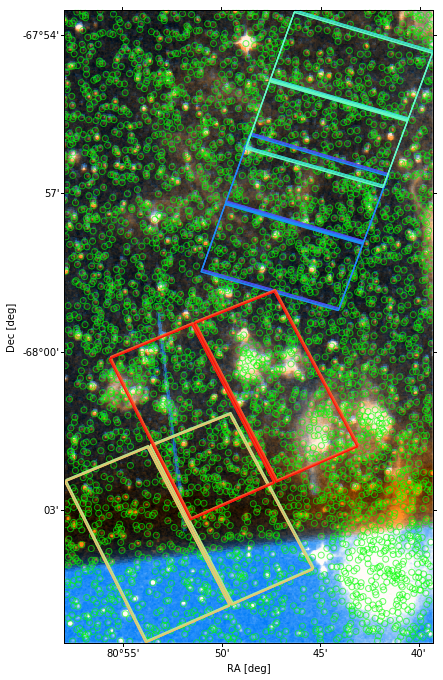

In [23]:
hdr = dss_r[0].header
wcs = WCS(hdr)
aspect_ratio = float(hdr['NAXIS1'])/hdr['NAXIS2'] # the float() ensures python2 compatibility


fig = plt.figure(figsize=(20.,20.*aspect_ratio))

ax = plt.subplot(projection=wcs) # matplotlib has support for axes using WCS projections!
ax.imshow(stack,origin='lower') # show the rgb image made in previous cell
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.tick_params(axis='both', which='major', labelsize=10)

ax.autoscale(False)

# Plot the Gaia sources on top of image
coord_alpha = 2000./len(r)+.1
ax.scatter(r['ra'],r['dec'],
           edgecolors='#00ff00',
           transform=ax.get_transform('icrs'), # This is needed when projecting onto axes with WCS info
           facecolors='none',
           alpha=coord_alpha)

# Plot the observation footprints on the image 
ax = plot_footprints(footprint_list, axes_obj=ax, fill=False)



***

<a id='alignment'></a>
## 3. Aligning data to Gaia
To align the data to Gaia, we will use DrizzlePac's TweakReg module, and pass it our catalog as an input reference catalog.
### a. Saving catalog
With the Gaia catalog retrieved, we now need to save the coordinates out to a file pass them to TweakReg for alignment.

In [24]:
from astropy.table import Table

tbl = Table([ras, decs]) # Make a temporary table of just the positions
tbl.write('gaia.cat', format='ascii.fast_commented_header') # Save the table to a file.  The format argument ensures
                                                            # the first line will be commented out.

We can also use our masking code to filter out sources before saving the final catalog:

In [25]:
thresh = 10.
mask = get_error_mask(r, thresh)

tbl_filtered = Table([ras[mask], decs[mask]]) 
tbl.write('gaia_filtered_{}_mas.cat'.format(thresh), format='ascii.fast_commented_header')

We can see that this simply wrote out text files:

In [26]:
ls *cat

gaia.cat                    gaia_filtered_10.0_mas.cat


### b. Running TweakReg
Generally, this step is similar to running TweakReg in other cases.  However, we are going to pass TweakReg our Gaia catalog as a reference, rather than having it create it's own catalog from the images itself.  Note that getting good alignments still requires good source detection in the input images, so some smart parameter selection may still be necessary, depending on the input data.

Before running TweakReg, we must update the WCS's of our data (only needs to be done for flt/flc data):

In [27]:
from stwcs import updatewcs

input_images = sorted(glob.glob('*fl?.fits')) 
derp = list(map(updatewcs.updatewcs, input_images))

# # Parallelized option
# p = Pool(8)
# derp = p.map(updatewcs.updatewcs, input_images)
# p.close()
# p.join()



- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 35 for chip 1 : F814W
- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 35 for chip 1 : F814W
- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 35 for chip 1 : F814W
- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 36 for chip 2 : F814W
- IDCTAB: Distortion model from row 35 for chip 1 : F814W
- IDCTAB: Distortion model from row 28 for chip 2 : F555W
- IDCTAB: Distortion model from row 28 for chip 2 : F555W
- IDCTAB: Distortion model from row 27 for chip 1 : F555W
- IDCTAB: Distortion model from row 28 for chip 2 : F555W
- IDCTAB: Distortion model from row 28 for chip 2 : F555W
- IDCTAB: Dist

- IDCTAB: Distortion model from row 48 for chip 2 : F555W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 47 for chip 1 : F555W


Setting up logfile :  tweakreg.log

TweakReg Version 1.4.3(01-Jul-2016) started at: 12:23:24.755 (31/10/2017)

Version Information

--------------------

Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10)
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]

numpy Version -> 1.12.1 

astropy Version -> 1.3.3 

stwcs Version -> 1.3.1rc.dev6 


Finding shifts for: 

    id7301giq_flc.fits

    id7301gkq_flc.fits

    id7301goq_flc.fits

    id7301gsq_flc.fits

    id7301gwq_flc.fits

    id7301h0q_flc.fits

    id7301h5q_flc.fits

    id7301h9q_flc.fits

    id7305lkq_flc.fits

    id7305lmq_flc.fits

    id7305lqq_flc.fits

    id7305luq_flc.fits

    id7305lyq_flc.fits

    id7305m1q_flc.fits

    id7305m5q_flc.fits

    id7305m9q_flc.fits

    jd7301gjq_flc.fits

    jd7301glq_flc.fits

    jd7301gpq_flc.fits

    jd7301gtq_flc.fits

    jd7301gxq_flc.fits

    jd7301h1q_flc.fits

    jd7301h6q_flc.fits

    jd7301haq_flc.fits

    jd7305llq_flc.fits




===  Found a TOTAL of 8280 objects in image 'jd7301gpq_flc.fits'



===  Source finding for image 'jd7301gtq_flc.fits':

  #  Source finding for 'jd7301gtq_flc.fits', EXT=('SCI', 1) started at: 12:24:12.677 (31/10/2017)

     Found 3689 objects.

  #  Source finding for 'jd7301gtq_flc.fits', EXT=('SCI', 2) started at: 12:24:13.706 (31/10/2017)

     Found 3564 objects.

===  Found a TOTAL of 7253 objects in image 'jd7301gtq_flc.fits'



===  Source finding for image 'jd7301gxq_flc.fits':

  #  Source finding for 'jd7301gxq_flc.fits', EXT=('SCI', 1) started at: 12:24:14.944 (31/10/2017)

     Found 7501 objects.

  #  Source finding for 'jd7301gxq_flc.fits', EXT=('SCI', 2) started at: 12:24:15.999 (31/10/2017)

     Found 6788 objects.

===  Found a TOTAL of 14289 objects in image 'jd7301gxq_flc.fits'



===  Source finding for image 'jd7301h1q_flc.fits':

  #  Source finding for 'jd7301h1q_flc.fits', EXT=('SCI', 1) started at: 12:24:17.612 (31/10/2017)

     Found 5063 objects.

  #  


Total # points:  338

# of points after clipping:  338


....Updating header for id7301goq_flc.fits...


Processing id7301goq_flc.fits['SCI',1]

Updating header for id7301goq_flc.fits[1]

WCSNAME  :  GAIA


Processing id7301goq_flc.fits['SCI',2]

Updating header for id7301goq_flc.fits[4]

WCSNAME  :  GAIA



Performing fit for: id7301gsq_flc.fits

Matching sources from 'id7301gsq_flc.fits' with sources from reference catalog 'gaia.cat'

Computing initial guess for X and Y shifts...

Found initial X and Y shifts of  -5.12289421946 2.97061227405

    with significance of  1726.03139717 and  257.0  matches

Found 373 matches for id7301gsq_flc.fits...

Computed  general  fit for  id7301gsq_flc.fits : 

XSH: -4.05107  YSH: 3.95353    PROPER ROT: 0.00870218    

<ROT>: 0.00870218  SKEW: 0.00130356    ROT_X: 0.0080504  ROT_Y: 0.00935397

<SCALE>: 1.0001  SCALE_X: 1.0001  SCALE_Y: 1.00011

XRMS: 0.0762074    YRMS: 0.0762119

RMS_RA: 2.8604e-06 (deg)   RMS_DEC: 5.08193e-07 (deg)

Final solutio


Updating header for id7305lmq_flc.fits[1]

WCSNAME  :  GAIA


Processing id7305lmq_flc.fits['SCI',2]

Updating header for id7305lmq_flc.fits[4]

WCSNAME  :  GAIA



Performing fit for: id7305lqq_flc.fits

Matching sources from 'id7305lqq_flc.fits' with sources from reference catalog 'gaia.cat'

Computing initial guess for X and Y shifts...

Found initial X and Y shifts of  -2.30908426703 -5.2463779964

    with significance of  1291.30817391 and  162.0  matches

Found 284 matches for id7305lqq_flc.fits...

Computed  general  fit for  id7305lqq_flc.fits : 

XSH: 0.338287  YSH: -3.98223    PROPER ROT: 0.0177912    

<ROT>: 0.0177912  SKEW: 0.000528211    ROT_X: 0.0175271  ROT_Y: 0.0180553

<SCALE>: 1.0001  SCALE_X: 1.0001  SCALE_Y: 1.0001

XRMS: 0.116278    YRMS: 0.0873701

RMS_RA: 4.07907e-06 (deg)   RMS_DEC: 4.75683e-07 (deg)

Final solution based on  255  objects.

wrote XY data to:  id7305lqq_flc_catalog_fit.match

Total # points:  255

# of points after clipping:  255

Total # poin


WCSNAME  :  GAIA



Performing fit for: jd7301glq_flc.fits

Matching sources from 'jd7301glq_flc.fits' with sources from reference catalog 'gaia.cat'

Computing initial guess for X and Y shifts...

Found initial X and Y shifts of  -4.40300047683 2.70237142399

    with significance of  2172.47120753 and  353.0  matches

Found 470 matches for jd7301glq_flc.fits...

Computed  general  fit for  jd7301glq_flc.fits : 

XSH: -4.82146  YSH: 2.9333    PROPER ROT: 0.00902948    

<ROT>: 0.00902948  SKEW: 4.63042e-05    ROT_X: 0.00900632  ROT_Y: 0.00905263

<SCALE>: 1.00008  SCALE_X: 1.00012  SCALE_Y: 1.00005

XRMS: 0.0954017    YRMS: 0.103681

RMS_RA: 3.6625e-06 (deg)   RMS_DEC: 7.21957e-07 (deg)

Final solution based on  438  objects.

wrote XY data to:  jd7301glq_flc_catalog_fit.match

Total # points:  438

# of points after clipping:  438

Total # points:  438

# of points after clipping:  438


....Updating header for jd7301glq_flc.fits...


Processing jd7301glq_flc.fits['SCI',1]

Updating


Computing initial guess for X and Y shifts...

Found initial X and Y shifts of  -0.164273980634 -5.31528069204

    with significance of  1486.9544101 and  190.0  matches

Found 535 matches for jd7305llq_flc.fits...

Computed  general  fit for  jd7305llq_flc.fits : 

XSH: -0.327159  YSH: -4.92465    PROPER ROT: 0.0179597    

<ROT>: 0.0179597  SKEW: 0.000311467    ROT_X: 0.0178039  ROT_Y: 0.0181154

<SCALE>: 1.00008  SCALE_X: 1.00012  SCALE_Y: 1.00005

XRMS: 0.101877    YRMS: 0.100934

RMS_RA: 3.81453e-06 (deg)   RMS_DEC: 6.69529e-07 (deg)

Final solution based on  497  objects.

wrote XY data to:  jd7305llq_flc_catalog_fit.match

Total # points:  497

# of points after clipping:  497

Total # points:  497

# of points after clipping:  497


....Updating header for jd7305llq_flc.fits...


Processing jd7305llq_flc.fits['SCI',1]

Updating header for jd7305llq_flc.fits[1]

WCSNAME  :  GAIA


Processing jd7305llq_flc.fits['SCI',2]

Updating header for jd7305llq_flc.fits[4]

WCSNAME  :  GA


    with significance of  1267.93707236 and  46.0  matches

Found 274 matches for jd7305maq_flc.fits...

Computed  general  fit for  jd7305maq_flc.fits : 

XSH: -1.40851  YSH: -4.47524    PROPER ROT: 0.0401466    

<ROT>: 0.0401466  SKEW: 0.00113267    ROT_X: 0.0395803  ROT_Y: 0.0407129

<SCALE>: 1.00002  SCALE_X: 1.00008  SCALE_Y: 0.999964

XRMS: 0.0839165    YRMS: 0.0910342

RMS_RA: 3.21995e-06 (deg)   RMS_DEC: 6.33331e-07 (deg)

Final solution based on  253  objects.

wrote XY data to:  jd7305maq_flc_catalog_fit.match

Total # points:  253

# of points after clipping:  253

Total # points:  253

# of points after clipping:  253


....Updating header for jd7305maq_flc.fits...


Processing jd7305maq_flc.fits['SCI',1]

Updating header for jd7305maq_flc.fits[1]

WCSNAME  :  GAIA


Processing jd7305maq_flc.fits['SCI',2]

Updating header for jd7305maq_flc.fits[4]

WCSNAME  :  GAIA

Writing out shiftfile : shifts.txt

Trailer file written to:  tweakreg.log



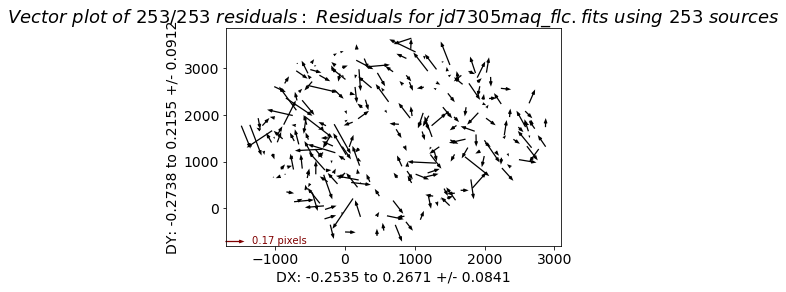

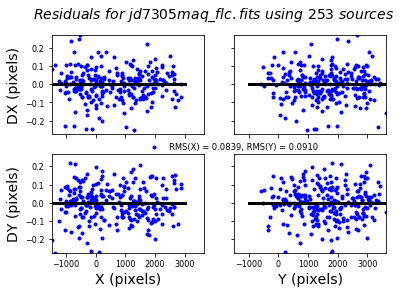

In [28]:
from drizzlepac import tweakreg
from stsci.tools import teal

cat = 'gaia.cat'
wcsname ='GAIA'
teal.unlearn('tweakreg')
teal.unlearn('imagefindpars')

cw = 3.5 # psf width measurement (2*FWHM).  Use 3.5 for WFC3/UVIS and ACS/WFC and 2.5 for WFC3/IR

tweakreg.TweakReg(input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':250.,'conv_width':cw},# Detection parameters, threshold varies for different data
                  separation=0.0, # Allow for very small shifts
                  refcat=cat, # Use user supplied catalog (Gaia)
                  clean=True, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname=wcsname, # Give our WCS a new name
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit

To look at how well the fit didm we can check the output shifts.txt file.


The columns in the file are: xshift, yshift, rotation, scale, xrms yrms

In [30]:
print(open('shifts.txt').read())

# frame: output
# refimage: shifts_wcs.fits[wcs]
# form: delta
# units: pixels
id7301giq_flc.fits    -4.030703  4.059132    0.009013     1.000104   0.073821  0.088791
id7301gkq_flc.fits    -4.080134  3.998806    0.008887     1.000105   0.075936  0.084918
id7301goq_flc.fits    -4.040332  3.990466    0.008935     1.000101   0.070864  0.081425
id7301gsq_flc.fits    -4.051072  3.953530    0.008702     1.000104   0.076207  0.076212
id7301gwq_flc.fits    -3.875390  4.200428    0.009259     1.000096   0.077883  0.087231
id7301h0q_flc.fits    -3.971728  4.093555    0.008987     1.000090   0.078194  0.088772
id7301h5q_flc.fits    -3.878624  4.082706    0.009081     1.000089   0.072909  0.082841
id7301h9q_flc.fits    -3.865993  4.111704    0.008825     1.000095   0.077081  0.083329
id7305lkq_flc.fits    0.482667  -3.850175    0.017994     1.000107   0.114221  0.080214
id7305lmq_flc.fits    0.415810  -3.944149    0.017973     1.000098   0.109423  0.079873
id7305lqq_flc.fits    0.338287  -3.982229

The X and Y RMS are generally .1 pixels or below (if you used the example dataset), indicating a rather good fit!

***
### Conclusion
At this point, the data is ready to be drizzled.  Better fits with even smaller residuals may be obtained by changing various parameters such as thresholds for source detection, and error budgets for Gaia sources, though the optimal set of parameters will vary between datasets.  Furthermore, the parameters shown here may not always work for other datasets, but tests using several very large datasets indicate that the performance is quite good with rough parameters.

However, trying to align single exposures is not always as easy as it was for this dataset, due to artifacts in the flts/flcs, such as cosmic rays, bad pixels, etc.  In the next notebook we present a workflow where we initially drizzle images taken in the same filter/visit (and would subsequently align those drizzled images similarly to how we did here). This method of processing is generally easier and faster, but may come at the expense of minimal levels of accuracy.
***

### More information
**Astroquery**: http://astroquery.readthedocs.io/en/latest/index.html

**Astropy Coordinates**: http://docs.astropy.org/en/stable/coordinates/

**Astropy Tables**: http://docs.astropy.org/en/stable/table/

**Astropy Units and Quantities**: http://docs.astropy.org/en/stable/units/

**Astropy WCS**: http://docs.astropy.org/en/stable/wcs/, 
http://docs.astropy.org/en/stable/visualization/wcsaxes/

**TweakReg**: http://stsdas.stsci.edu/stsci_python_sphinxdocs_2.13/drizzlepac/tweakreg.html,
http://drizzlepac.stsci.edu/